In [1]:
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import time
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from kalman_filter import Kalman1D


# 1 数据读取

In [23]:
stock_name = 'AAPL'
data = pd.read_csv('StockData/{}.csv'.format(stock_name))

In [24]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-12-03,46.115002,46.235001,45.302502,46.205002,44.231552,163210000
1,2018-12-04,45.237499,45.597500,44.067501,44.172501,42.285866,165377200
2,2018-12-06,42.939999,43.695000,42.605000,43.680000,41.814392,172393600
3,2018-12-07,43.372501,43.622501,42.075001,42.122501,40.323410,169126400
4,2018-12-10,41.250000,42.522499,40.832500,42.400002,40.589066,248104000
...,...,...,...,...,...,...,...
1011,2022-12-08,142.360001,143.520004,141.100006,142.649994,141.484406,62128300
1012,2022-12-09,142.339996,145.570007,140.899994,142.160004,140.998398,76097000
1013,2022-12-12,142.699997,144.500000,141.059998,144.490005,143.309372,70462700
1014,2022-12-13,149.500000,149.970001,144.240005,145.470001,144.281372,93886200


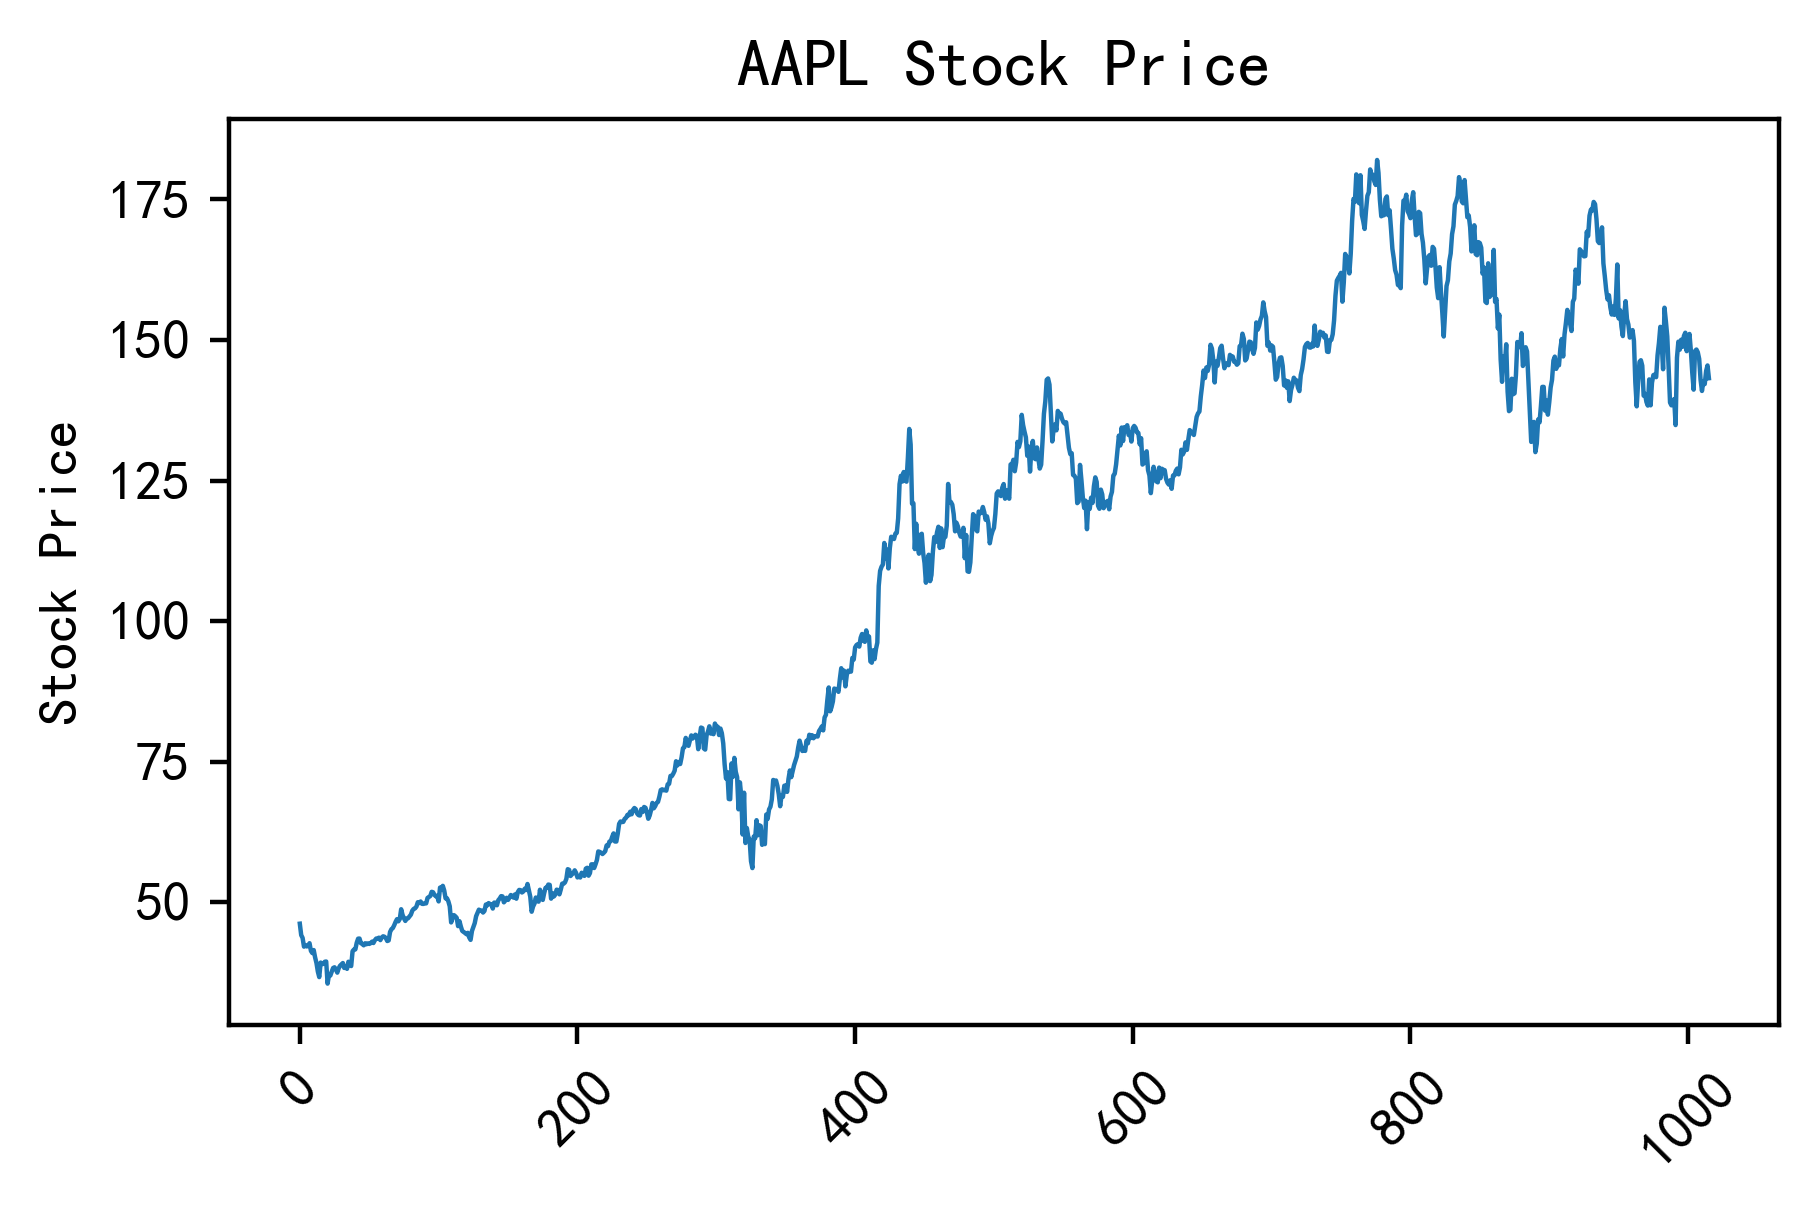

In [25]:
plt.figure(figsize=(5,3),dpi=400)
plt.plot(data["Close"],'-',linewidth=0.8)
plt.ylabel("Stock Price")
# 旋转 x 轴日期标签
plt.xticks(rotation=45)
plt.title(f"{y_symbols[0]} Stock Price")
plt.show()

# 2 数据集处理

误差为：0.734013


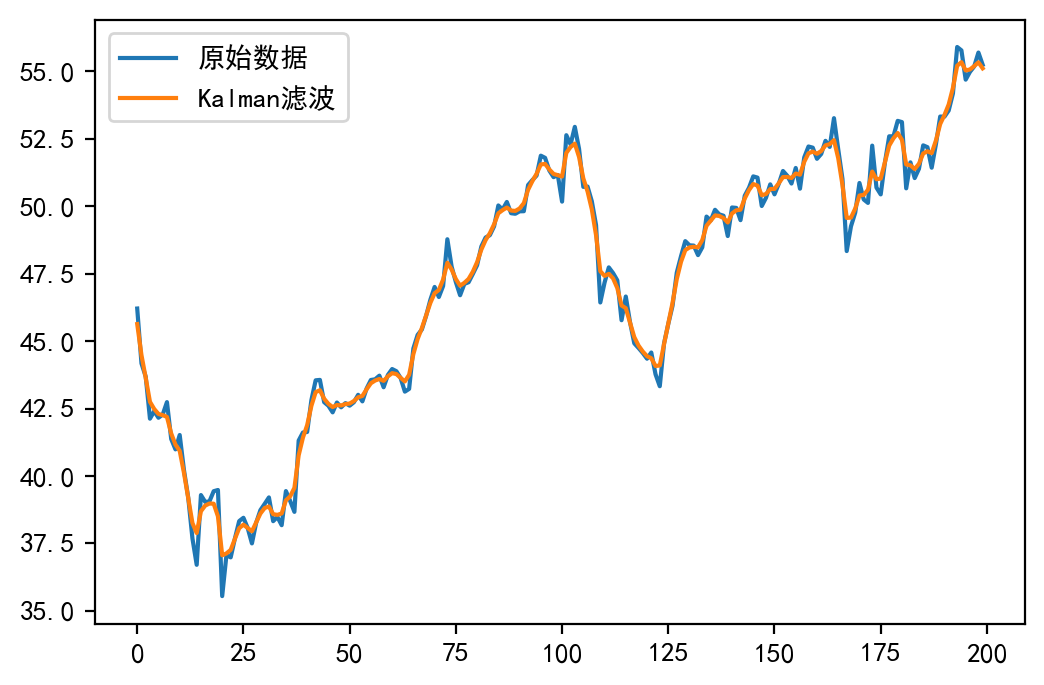

In [26]:
data_size=1200
Origin= data['Close'][:data_size].values.astype(float)    #用于训练和验证

filter_data=Kalman1D(Origin,0.1)

Origin_data=filter_data

error=np.sum(np.abs(Origin-filter_data.flatten()))/len(Origin)
print("误差为：{:.6f}".format(error))
vision_end=200
plt.figure(figsize=(6,4),dpi=200)
plt.plot(list(Origin)[:vision_end],label="原始数据")
plt.plot(filter_data[:vision_end],label="Kalman滤波")
plt.legend()
plt.show()

1.2447012503316084


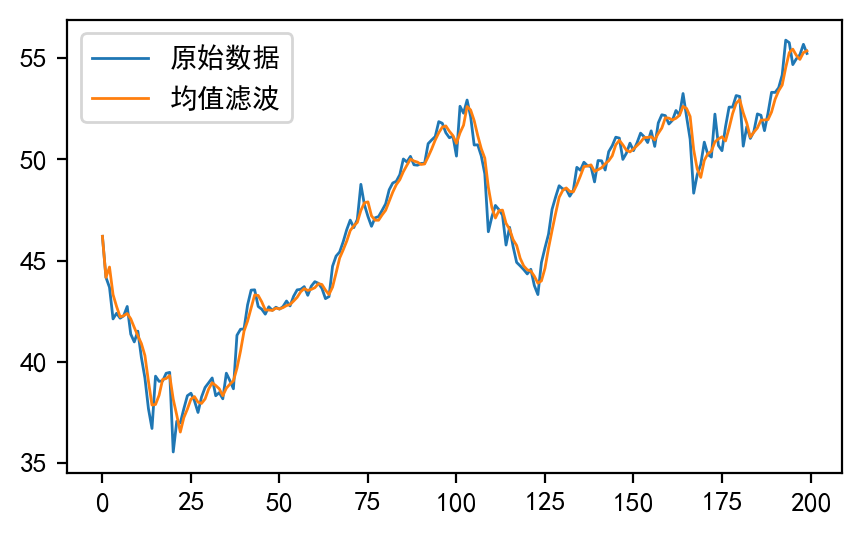

In [27]:
wd=3
r = data['Close'][:data_size].rolling(window=wd)#使用2作为窗口长度
ma_filter=r.mean()
ma_filter[:wd-1]=Origin[:wd-1]
print(np.sum(np.abs(ma_filter-Origin))/len(ma_filter))

end=200
plt.figure(figsize=(5,3),dpi=200)
plt.plot(Origin[:end],label="原始数据",linewidth=1)
plt.plot(list(ma_filter[:end]),label="均值滤波",linewidth=1)
plt.xticks(rotation=0)
plt.legend()
plt.show()

# 3 获得训练数据及标签

In [28]:
Origin_data=filter_data   #选择源数据

In [29]:
window_size = 5      #输入size，也可以理解为用前几个预测后一个
X=[]        
label=[]

for i in range(len(Origin_data)-window_size-1):
    seq=Origin_data[i:i+window_size]                                  #输入序列
    #target=np.square(np.log(Origin_data[i+window_size]))             #后一天作为标签
    target=Origin_data[i+window_size]
    X.append(seq)
    label.append(target)


"""数据集加载器"""
class Dataset(torch.utils.data.Dataset):
    def __init__(self,data,labels):
        self.data=data
        self.labels=labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        
        return torch.FloatTensor(self.data[index]).view(-1),torch.FloatTensor((self.labels[index]).reshape(1))

train_set=Dataset(X,label)
train_data=DataLoader(train_set,shuffle=True,batch_size=1)    #训练数据集

print("训练数据集大小：",len(train_data))

训练数据集大小： 1010


# 4 CNN模型

In [30]:
kernel_size=2   #一维卷积核大小

class CNNmodel(nn.Module):
    def __init__(self):
        super(CNNmodel, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=kernel_size)   #1xkersize的卷积核 
        #self.conv2 = nn.Conv1d(64,128,1)
        self.relu = nn.ReLU(inplace=True)
        self.Linear1 = nn.Linear(64*(window_size-kernel_size+1), 10)
        self.Linear2 = nn.Linear(10, 1)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        return x

model = CNNmodel()
print(model)


CNNmodel(
  (conv1): Conv1d(1, 64, kernel_size=(2,), stride=(1,))
  (relu): ReLU(inplace=True)
  (Linear1): Linear(in_features=256, out_features=10, bias=True)
  (Linear2): Linear(in_features=10, out_features=1, bias=True)
)


# 5 训练

100%|██████████| 30/30 [00:11<00:00,  2.59it/s]


Duration: 12 seconds


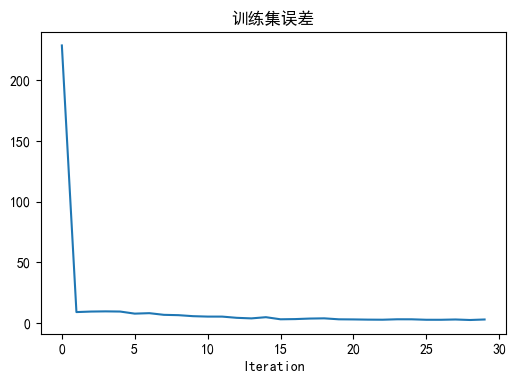

In [31]:
model = CNNmodel()         #模型
lr=0.001                   #学习率
epochs = 30                #迭代次数
criterion = nn.MSELoss()   #损失函数                               
optimizer = torch.optim.Adam(model.parameters(), lr=lr)                     #优化器
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)  #学习率调优


start_time = time.time()
Loss=[]     #储存训练误差
Val_Loss=[] #储存验证误差

for epoch in tqdm(range(epochs)):
    
    '''训练'''
    i=0
    now_loss=0
    model.train()   #训练模式
    for seq, y_train in train_data:
    
        optimizer.zero_grad()
                                        
        y_train=y_train.view(1)
        y_pred = model(seq.reshape(1,1,-1))    # 转化为网络输入的大小(batch size, channel, series length）
        
        loss = criterion(y_pred, y_train)
        loss.backward()                        #梯度回传
        optimizer.step()                       #优化器更新
        
        #scheduler.step()
        
        now_loss+=loss.item()
        i+=1

    '''验证'''
    model.eval()    #验证模式
    valid_loss=0
    j=1
    for seq, y_val in train_data:
        break
        y_val=y_val.view(1)
        y_pred = model(seq.reshape(1,1,-1))
        loss = criterion(y_pred, y_val)
        j+=1
        valid_loss+=loss.item()
    
    Loss.append(now_loss/i)
    Val_Loss.append(valid_loss/j)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')
fig=plt.figure(figsize=(6,4),dpi=100)
ax1=plt.subplot(111)
ax1.plot(Loss)
ax1.set_title("训练集误差")
ax1.set_xlabel("Iteration")
# plt.setp(ax1.get_xticklabels())       #共享y轴
# ax2=plt.subplot(122,sharey=ax1)    
# ax2.plot(Val_Loss)
# ax2.set_title("验证集误差")
# ax2.set_xlabel("Iteration")

plt.show()


# 6 拟合效果

平均误差为：0.43
相对误差率：0.93%


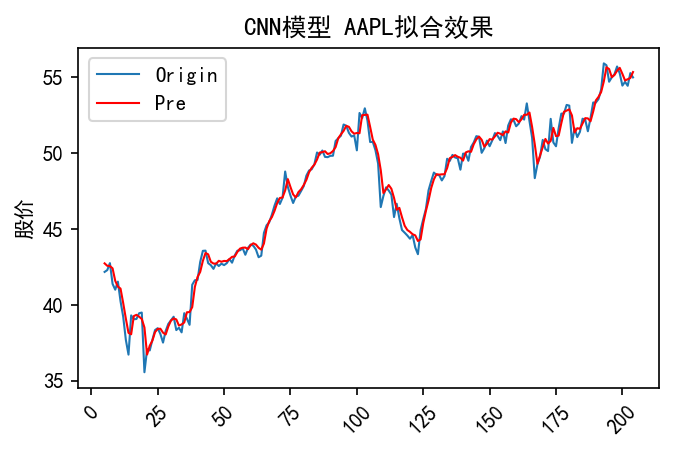

In [32]:
pre=[]
model.eval()
pred_num=200
for i in range(pred_num):
    seq = torch.FloatTensor(Origin_data[i:i+window_size])
    with torch.no_grad():
        #pre.append(np.exp(np.sqrt(model(seq.reshape(1,1,-1)).item())))
        pre.append(model(seq.reshape(1,1,-1)).item())


error=np.sum(np.abs(pre-Origin[window_size:window_size+pred_num]))/len(pre)
error_rate=np.sum(np.abs(pre-Origin[window_size:window_size+pred_num])/np.abs(Origin[window_size:window_size+pred_num]))/len(pre)
print("平均误差为：{:.2f}".format(error))
print("相对误差率：{:.2f}%".format(error_rate*100))


plt.figure(figsize=(5,3),dpi=150)
plt.plot(data.index[window_size:window_size+pred_num],Origin[window_size:window_size+pred_num],label="Origin",linewidth=1)
plt.plot(data.index[window_size:window_size+pred_num],pre,'r',linewidth=1,label="Pre")
plt.title(f"CNN模型 {stock_name}拟合效果")
plt.xticks(rotation=45)
plt.ylabel("股价")

plt.legend()
plt.show()